In [1]:
import os
import numpy as np
import cv2
from tqdm import tqdm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
BASE_DIR = "/kaggle/input/brain-tumor-mri-classification"

TRAIN_DIR = os.path.join(BASE_DIR, "Training", "Training")
TEST_DIR  = os.path.join(BASE_DIR, "Testing", "Testing")

IMG_SIZE = 64


In [3]:
from skimage.feature import hog

def extract_features(img):

    features = hog(
        img,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys'
    )
    return features.astype("float32")

def load_data_from_dir(root_dir):
    X, y = [], []
    class_names = sorted(os.listdir(root_dir))

    for cls in class_names:
        cls_path = os.path.join(root_dir, cls)
        if not os.path.isdir(cls_path):
            continue

        for fname in tqdm(os.listdir(cls_path), desc=f"Loading {cls}", leave=False):
            fpath = os.path.join(cls_path, fname)
            img = cv2.imread(fpath)
            if img is None:
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

            feat = extract_features(img)
            X.append(feat)
            y.append(cls)

    return np.array(X), np.array(y), class_names


In [4]:
print("Завантаження train...")
X_train, y_train, class_names = load_data_from_dir(TRAIN_DIR)

print("Завантаження test...")
X_test, y_test, _ = load_data_from_dir(TEST_DIR)

print("Форма X_train:", X_train.shape)
print("Форма X_test:", X_test.shape)
print("Класи:", class_names)


Завантаження train...


Завантаження test...


Форма X_train: (32080, 1764)
Форма X_test: (8020, 1764)
Класи: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [5]:
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

pca = PCA(n_components=150)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)


knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
knn.fit(X_train_pca, y_train)
y_pred = knn.predict(X_test_pca)


In [6]:
knn = KNeighborsClassifier(
    n_neighbors=5,
    weights="distance",
    metric="euclidean"
)

print("Навчання K-NN...")
knn.fit(X_train_scaled, y_train)


Навчання K-NN...


KNeighborsClassifier(metric='euclidean', weights='distance')

In [7]:
y_pred = knn.predict(X_test_scaled)

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=class_names))



Classification report:
              precision    recall  f1-score   support

      glioma       0.68      0.48      0.56      1886
  meningioma       0.56      0.37      0.45      1879
     notumor       0.75      0.94      0.84      2317
   pituitary       0.65      0.85      0.74      1938

    accuracy                           0.68      8020
   macro avg       0.66      0.66      0.64      8020
weighted avg       0.66      0.68      0.66      8020



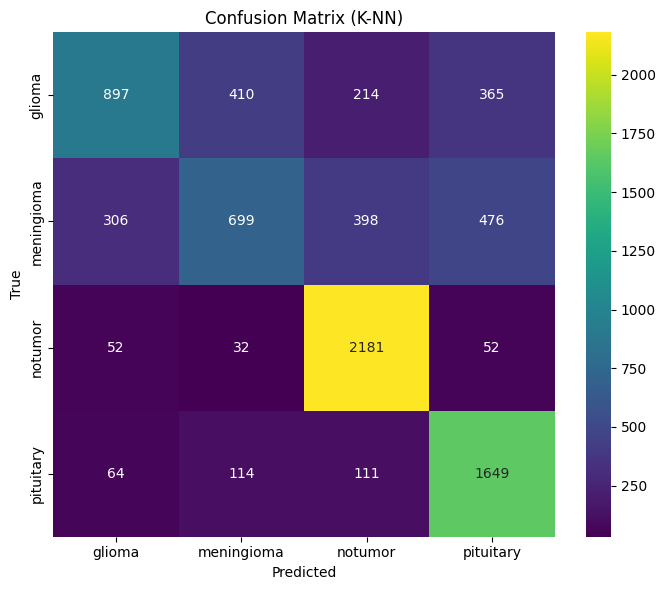

In [8]:
cm = confusion_matrix(y_test, y_pred, labels=class_names)

plt.figure(figsize=(7,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="viridis",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (K-NN)")
plt.tight_layout()
plt.show()


In [9]:
import joblib

SAVE_DIR = "/kaggle/working/knn_model"

os.makedirs(SAVE_DIR, exist_ok=True)

joblib.dump(knn, os.path.join(SAVE_DIR, "knn_model.pkl"))
joblib.dump(scaler, os.path.join(SAVE_DIR, "scaler.pkl"))
joblib.dump(class_names, os.path.join(SAVE_DIR, "class_names.pkl"))

print(f"Модель збережено у {SAVE_DIR}")


Модель збережено у /kaggle/working/knn_model
